In [2]:
# hide
import matplotlib.patches
from matplotlib.patches import Rectangle, Ellipse, FancyArrow, Arrow
import matplotlib.pyplot as plt
import numpy as np


class canvas:
    def __init__(self, figsize, pixsize):
        plt.figure(figsize=figsize)
        self.pixsize = pixsize
        self.ax = ax = plt.gca()
        #self.ax.set_frame_on(False)
        self.ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
        self.ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 
        self.ax.set_xlim(0, 1)
        self.ax.set_ylim(0, 1)
    def get_ax(self):
        return self.ax
    def _normalize(self, p):
        return (p[0] / self.pixsize[0], p[1] /self.pixsize[1])
    def rect(self, p, width, height, label=None, label_color=None, **attr):
        sp = self._normalize(p)
        sw, sh = self._normalize((width,height))
        self.ax.add_patch(Rectangle(sp, sw, sh, **attr))
        if label:
            self.ax.text(sp[0] + sw/2, sp[1] + sh/2, label, color=label_color, ha="center", va="center")
    def ellipse(self, p, width, height, label=None, label_color=None, **attr):
        sp = self._normalize(p)
        sw, sh = self._normalize((width,height))
        self.ax.add_patch(Ellipse(sp, sw, sh, **attr))
        if label:
            self.ax.text(sp[0], sp[1], label, color=label_color, ha="center", va="center")
    def arrow(self, p, width, height, label=None, label_offset=(0,0), label_color=None, **attr):
        sp = self._normalize(p)
        sw, sh = self._normalize((width,height))
        self.ax.add_patch(FancyArrow(sp[0], sp[1], sw, sh, width=0.01, length_includes_head=True, **attr))
        dx, dy = self._normalize(label_offset)
        if label:
            self.ax.text(sp[0] + sw/2 + dx, sp[1] + sh/2 + dy, label, color=label_color, ha="center", va="center")
    def text(self, p, label, **attr):
        sp = self._normalize(p)
        self.ax.text(sp[0], sp[1], label, **attr)


# 4. モデルの評価とパラメータチューニング

## 4.1 機械学習のフロー

- 訓練セットとテストセットに分割する
- モデルを構築し、チューニングする
    - 訓練セットを訓練用データと検証用データに分割
    - 訓練用データで訓練したモデルを、検証用データで評価
    - 検証用データでの評価結果が良くなるように、モデルのハイパーパラメータを更新
- テストセットでモデルを評価

<img src="images/training-test.png" width="500"/>

機械学習の一般的な作業の流れ

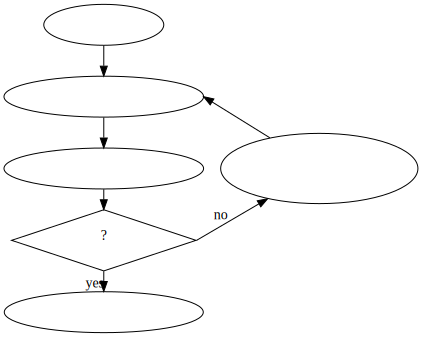

In [4]:
# hide
import graphviz

dot = graphviz.Digraph('training-flow', engine='neato')
dot.node('mc', 'モデル作成', pos="0,8!")
dot.node('tr', '訓連用データで訓連', pos="0,7!")
dot.node('hpt', 'ハイパーパラメータ\nチューニング', pos="3,6!")
dot.node('val', '検証用データで評価', pos="0,6!")
dot.node('div', '十分よいか?', shape='diamond', pos="0,5!")
dot.node('test', 'テストセットで評価', pos= "0,4!")
dot.edge('mc', 'tr')
dot.edge('tr', 'val')
dot.edge('hpt', 'test', style='invis')
dot.edge('val', 'div')
dot.edge('div:e', 'hpt', label='no')
dot.edge('hpt', 'tr:e', minlen = '1')
dot.edge('div', 'test', label='yes')
dot



#### 注意点
- テストセットは最後のモデル評価以外では使ってはいけない
- テストセットを使ってハイパーパラメータチューニングするのは**絶対に**禁止
    - しりたいのは未見のデータに対する性能。テストセットは未見データの代用
    - テストセットに対してチューニングすると、未見ではなくなるので意味がない

####  単純な分割の限界
訓練セットを訓練用データと検証用データに単純に分割すると
- データの量がたりなくなる
- 訓練用データに含まれているデータ点に対する評価がハイパーパラメータチューニングに反映されない


## 4.2 交差検証

訓練用データと検証用データの分割を何度も繰り返す。
- すべての訓連セットデータを用いてモデルを訓練し
- すべての訓連セットデータを用いてモデルを評価できる

#### k分割交差検証

- 訓練セットをk個に分割
- そのうちの一つを検証用とし、残りを訓練用に用いて評価
- これをk回繰り返し、平均値をスコアとして採用する

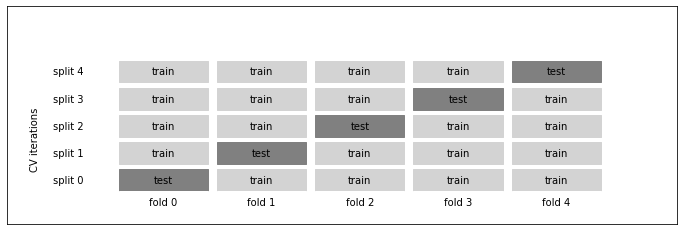

In [3]:
# hide
c = canvas((12,4), (600, 200))

off = (100, 30)
r_size = (80, 20)
r_gap = (8, 5)
div = 5
for x in range(div):
    for y in range(div):
        color = "gray" if x == y else "lightgray"
        label = "test" if x == y else "train"
        c.rect((off[0] + (r_size[0] + r_gap[0]) * x, off[1] + (r_size[1] + r_gap[1]) * y), r_size[0], r_size[1], label = label, color=color)

for x in range(div):
    c.rect((off[0] + (r_size[0] + r_gap[0]) * x, 10), r_size[0], r_size[1], label = "fold {}".format(x), color="w")

for y in range(div):
    c.rect((15, off[1] + (r_size[1] + r_gap[1]) * y), r_size[0], r_size[1], label = "split {}".format(y), color="w")

c.text((20, 50), "CV iterations", rotation=90)
"5分割交差検証"

乳癌データセットと、ロジスティック回帰を用いた実行例

In [9]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split

# データセットの読み込み
cancer = load_breast_cancer()
ss = StandardScaler()
# 訓連・テスト データセットを分割
X = cancer.data
y = cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# 標準化
ss.fit(X_train)
X_train_s = ss.transform(X_train)
X_test_s = ss.transform(X_test)

# X_train_s に対して交差検証
mdl = LogisticRegression()
scores = cross_val_score(mdl, X_train_s, y_train)
print("Scores: {}\nAverage: {}".format(scores, scores.mean()))


Scores: [0.98837209 0.98823529 0.95294118 1.         0.97647059]
Average: 0.9812038303693571


スコアには1から0.95 まで、5%もの幅があることがわかる。

#### 1つ抜き交差検証
- k分割交差検証の考え方を極限まで推し進めた方法
- k=データセットサイズ 
- 1サンプルのみを検証、残りすべてを訓練に使う
- これをサンプル数だけ繰り返す




In [10]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
mdl = LogisticRegression()
scores = cross_val_score(mdl, X_train_s, y_train, cv=loo)
print("Scores: {}\nAverage: {}".format(scores, scores.mean()))


Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

交差検証の問題点
- 訓練をk回くりかえすことになり、時間がかかる
- 訓練に長大な時間がかかるディープラーニング界隈ではあまり用いられない　

## 4.3 グリッドサーチ

- モデルの性能を向上させるには、ハイパーパラメータチューニングが必要
- 複数のハイパーパラメータがある場合、すべてのハイパーパラメータの候補値の組み合わせを尽くす必要がある
- グリッド格子状にパラメータを設定して最良の組み合わせを探索する
- 注意: グリッドサーチには、テストセットを用いず、検証用データを用いること

> **ハイパーパラメータ**  
> 学習モデルの学習対象となるパラメータ(重み)では**なく**、
> モデルそのもののパラメータのこと。通常のパラメータ特別するためにこう呼ぶ


In [14]:
from sklearn.svm import SVC
gammas = [0.001, 0.01, 0.1, 1, 10]
Cs = [0.001, 0.01, 0.1, 1, 10]

results = []
for gamma in gammas:
    inner = []
    for C in Cs:
        mdl = SVC(gamma=gamma, C=C)
        scores = cross_val_score(mdl, X_train_s, y_train)
        inner.append(scores.mean())
    results.append(inner)
results

[[0.6267578659370725,
  0.6267578659370725,
  0.690123119015048,
  0.9413679890560875,
  0.9741723666210671],
 [0.6267578659370725,
  0.6267578659370725,
  0.9414227086183311,
  0.9741723666210671,
  0.9858823529411765],
 [0.6267578659370725,
  0.6267578659370725,
  0.9390150478796169,
  0.9530232558139536,
  0.9389329685362519],
 [0.6267578659370725,
  0.6267578659370725,
  0.6267578659370725,
  0.6314363885088918,
  0.6314363885088918],
 [0.6267578659370725,
  0.6267578659370725,
  0.6267578659370725,
  0.6267578659370725,
  0.6267578659370725]]

ヒートマップによる可視化
- 直感的な把握が可能
- ハイパーパラメータ2つの場合にしか使用できない

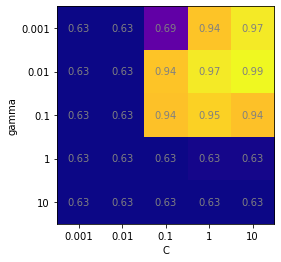

In [32]:
# hide
import matplotlib.pyplot as plt
import matplotlib.cm as cm

ax = plt.gca()
ax.imshow(results, cmap=cm.plasma)

ax.set_xticks(np.arange(len(Cs)), labels=Cs)
ax.set_yticks(np.arange(len(gammas)), labels=gammas)
ax.set_xlabel("C")
ax.set_ylabel("gamma")

for c in range(len(Cs)):
    for g in range(len(gammas)):
        ax.text(c, g, "{:0.2f}".format(results[g][c]), 
                ha="center", va="center", color="gray")

グリッドサーチは多用されるので専用のクラスが用意されている。Estimatorという枠組みで、モデルと同様に扱うことができる。

In [39]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(SVC(), {'C': Cs, 'gamma': gammas}, cv=5)

# モデルと同じように訓練する
grid_search.fit(X_train_s, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'gamma': [0.001, 0.01, 0.1, 1, 10]})

In [40]:
grid_search.best_params_

{'C': 10, 'gamma': 0.01}

In [41]:
grid_search.score(X_test_s, y_test)

0.9790209790209791

個々の訓練に長大な時間がかかる場合や、パラメータ空間が広大な場合にはグリッドサーチは現実的ではない。
ディープラーニングでは、ベイズ最適化と呼ばれる手法を用いた最適化技法が用いられる。
これは最小限の試行で最適なハイパーパラメータを

## 4.4 評価基準とスコア
### 4.4.1 混同行列 (Confusion Matrix)

予測と実際の陽性(Positive)、陰性(Negative)をマトリクス状にプロットしたもの
- 真陽性 TP True Positive    正しく陽性であると認識された
- 偽陰性 FN False Negative   本当は陽性だが誤って陰性だと判断されたもの
- 偽陽性 FP False Positive   本当は陰性だが誤って陽性だと判断されたもの
- 真偽性 TN True Negative    正しく陰性であると判断されたもの


| 実際\予測 |   陽   |  陰 |
|:-----:|:--------:|:------:|
| 陽| 真陽性 TP | 偽陰性 FN |
| 陰| 偽陽性 FP | 真偽性 TN |


#### 陽性と陰性
- 注目する観点によってどちらになるかが決まる。良いこと、悪いことというニュアンスはない。
- 例えば癌の診断であれば、良性、悪性のどちらを陽性にするかは、データ解析者が恣意的に決めることであって、
先験的に決定することではない。

#### 偽陰性と偽陽性
- 基本的にトレードオフの関係にある
    - どちらかを減らそうとすると、もう一方が増大する
    - 多くの場合パラメータを変更することで調整可能
- 一方だけをへらすのは非常に簡単
    - 常に陽性であると判定すれば偽陰性はなくなる
    - 常に陰性であると判定すれば偽陽性はなくなる
- 場合によって、どちらのほうが「より許容できるか」が異なる
- 例: 病気の診断で、病気であることを陽性とする場合
    - 病気が致命的で追加検査が侵食的でない場合: 偽陽性が好ましい\
    $\rightarrow$ 広くスクリーニングして、積極的に追加検査するべき
    - 病気が致命的でなく追加検査が侵食的である場合: 偽陰性が好ましい\
    $\rightarrow$ 誤って追加検査するよりは、病気を見逃したほうがトータルで負荷が少ない





### 4.4.2 精度とその限界

- 精度(Accuracy)

  正しく分類されたサンプル数の割合
  $$ 精度 = \frac{|TP|+|TN|}{|TP|+|TN|+|FP|+|FN|} $$

- 問題点: 偏りのあるデータに対する評価に適さない

  例: 晴天率が90%である地方で、常に晴天であると予測する - 精度 90% だが実は全く意味のないモデルになっている

  | 実際\予測|  陽   |  陰 |
  |:-----:|:--------:|:------:|
  | 陽| TP = 90 | FN = 0|
  | 陰| FP = 10 | TN = 0|




### 4.4.3 その他の指標
#### 適合率 (precision)
陽性であると予測されたのサンプルのうち、実際に陽性だった割合

$$ 適合率 = \frac{|TP|}{|TP|+|FP|} $$

#### 再現率 (recall)
実際に陽性のサンプルのうち、正しく陽性と予測された割合。

$$ 再現率 = \frac{|TP|}{|TP|+|FN|} $$

#### いずれも単独では十分ではない



#### f-値  
適合率と再現率をバランス良くまとめるために、調和平均をとったもの。

$$ f値 = 2 \times \frac{適合率 \times 再現率}{適合率 + 再現率} = \frac{2|TP|}{2|TP| + |FP| + |FN|} $$

### 4.4.4 誤差の評価 - MSE と MAE
誤差を単純に加算したのでは、+方向の誤差と-方向の誤差が打ち消し合うのでダメ

- MSE (Mean Squared Error) - 平均二乗誤差
$$ \frac{1}{n} \sum_{i=0}^{n}(\hat{y_i} - y_i)^{2}$$
- MAE (Mean absolute Error) - 平均絶対誤差
$$ \frac{1}{n} \sum_{i=0}^{n}|(\hat{y_i} - y_i)|$$

MSEは大きい誤差に対してより強くペナルティが効く。